In [ ]:
%pip install prophet

In [24]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# -------------------------
# Step 1: Load and Filter Data
# -------------------------
df = pd.read_csv("normalized_data.csv")

lung_df = df[
    (df['cancer_name'].str.lower() == 'lung') &
    (df['measure'].str.lower() == 'incidence')
].copy()
lung_df['rate_per_million'] = lung_df['rate'] * 1e6

# -------------------------
# Step 2: Historical CAGR
# -------------------------
def compute_cagr(group):
    start_year = group['year'].min()
    end_year = group['year'].max()
    start_rate = group[group['year'] == start_year]['rate'].values[0]
    end_rate = group[group['year'] == end_year]['rate'].values[0]
    periods = end_year - start_year
    if start_rate == 0 or periods == 0:
        return 0
    return (end_rate / start_rate) ** (1 / periods) - 1

historical_cagr = lung_df.groupby('country_name').apply(compute_cagr).reset_index(name='historical_cagr')

# -------------------------
# Step 3: Forecast CAGR + Pandemic Year (Post-Observation Only)
# -------------------------
THRESHOLD = 437.97
forecasted_cagrs = []
pandemic_years = []

for country in lung_df['country_name'].unique():
    country_df = lung_df[lung_df['country_name'] == country]
    df_prophet = country_df[['year', 'rate_per_million']].rename(columns={'year': 'ds', 'rate_per_million': 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

    if len(df_prophet) < 3:
        print(f"⛔ Skipping {country}: not enough data")
        forecasted_cagrs.append({'country_name': country, 'forecast_cagr': 0})
        pandemic_years.append({'country_name': country, 'year_of_pandemic_risk': None})
        continue

    try:
        model = Prophet(yearly_seasonality=False, daily_seasonality=False)
        model.fit(df_prophet)
        future = model.make_future_dataframe(periods=76, freq='Y')  # to 2100
        forecast = model.predict(future)

        # Use raw historical data for last observation year
        last_obs_year = country_df['year'].max()
        start_year = country_df['year'].min()
        start_val = country_df[country_df['year'] == start_year]['rate_per_million'].values[0]
        end_forecast = forecast.iloc[-1]
        end_val = end_forecast['yhat']
        end_year = end_forecast['ds'].year

        forecast_cagr = ((end_val / start_val) ** (1 / (end_year - start_year)) - 1) if start_val > 0 else 0
        forecasted_cagrs.append({'country_name': country, 'forecast_cagr': forecast_cagr})

        # Only use post-observation forecast for pandemic threshold check
        forecast_only = forecast[forecast['ds'].dt.year > last_obs_year]
        cross = forecast_only[forecast_only['yhat'] >= THRESHOLD]
        pandemic_year = int(cross.iloc[0]['ds'].year) if not cross.empty else None
        pandemic_years.append({'country_name': country, 'year_of_pandemic_risk': pandemic_year})

    except Exception as e:
        print(f"🔥 Forecast failed for {country}: {e}")
        forecasted_cagrs.append({'country_name': country, 'forecast_cagr': 0})
        pandemic_years.append({'country_name': country, 'year_of_pandemic_risk': None})

forecast_cagr_df = pd.DataFrame(forecasted_cagrs)
pandemic_year_df = pd.DataFrame(pandemic_years)

# -------------------------
# Step 4: Risk Score from Factors
# -------------------------
risk_factors = ['air_pollution', 'alcohol_use', 'obesity_rate', 'tobacco_use']
lung_df['risk_score'] = lung_df[risk_factors].mean(axis=1)
avg_risk_score = lung_df.groupby('country_name')['risk_score'].mean().reset_index()

# -------------------------
# Step 5: Merge & Normalize
# -------------------------
risk_index_df = historical_cagr.merge(forecast_cagr_df, on='country_name', how='outer')
risk_index_df = risk_index_df.merge(avg_risk_score, on='country_name', how='left')

scaler = MinMaxScaler()
risk_index_df[['historical_cagr_norm', 'forecast_cagr_norm', 'risk_score_norm']] = scaler.fit_transform(
    risk_index_df[['historical_cagr', 'forecast_cagr', 'risk_score']]
)

risk_index_df['pandemic_risk_index'] = (
    0.4 * risk_index_df['forecast_cagr_norm'] +
    0.3 * risk_index_df['historical_cagr_norm'] +
    0.3 * risk_index_df['risk_score_norm']
)

# Merge pandemic year
final_df = risk_index_df.merge(pandemic_year_df, on='country_name', how='left')

# -------------------------
# Step 6: Risk Flag Logic
# -------------------------
def updated_risk_flag(row):
    if row['pandemic_risk_index'] >= 0.66 or pd.notnull(row['year_of_pandemic_risk']):
        return 'High'
    elif row['pandemic_risk_index'] >= 0.33:
        return 'Moderate'
    return 'Low'

final_df['risk_flag'] = final_df.apply(updated_risk_flag, axis=1)

# -------------------------
# Step 7: Display and Save
# -------------------------
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(final_df)

final_df.to_csv("lung_cancer_pandemic_risk_index.csv", index=False)

/var/folders/1d/k5qf2m1x45nd7l3rh4619t8r0000gp/T/ipykernel_63233/1166239535.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  historical_cagr = lung_df.groupby('country_name').apply(compute_cagr).reset_index(name='historical_cagr')
20:45:39 - cmdstanpy - INFO - Chain [1] start processing
20:45:39 - cmdstanpy - INFO - Chain [1] done processing
/Users/mira-ali/BAU/data_analytics/cancer_incidence_mortality/cancer_measures/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
20:45:39 - cmdstanpy - INFO - Chain [1] start processing
20:45:39 - cmdstanpy - INFO - Chain 

             country_name  historical_cagr  forecast_cagr  risk_score  \
0               Argentina         0.008224       0.004165   18.922118   
1               Australia         0.010732       0.010028   15.327997   
2                 Austria         0.009255       0.011033   20.508841   
3                 Bahrain        -0.009365            NaN   29.797679   
4                 Belarus         0.001452      -0.000705   23.598537   
5                  Canada         0.007378       0.009897   15.279482   
6                   Chile        -0.006349       0.007320   24.426550   
7                   China         0.049552       0.021904   21.032187   
8                Colombia         0.022530       0.010030   13.036280   
9              Costa Rica        -0.007556      -0.000493   14.531347   
10                Croatia        -0.001282      -0.006640   23.215870   
11                 Cyprus         0.036981       0.020986   21.764854   
12                Denmark         0.001735      -0.

/Users/mira-ali/BAU/data_analytics/cancer_incidence_mortality/cancer_measures/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [26]:
final_df.sort_values('pandemic_risk_index', ascending=False).head(10)

,country_name,historical_cagr,forecast_cagr,risk_score,historical_cagr_norm,forecast_cagr_norm,risk_score_norm,pandemic_risk_index,year_of_pandemic_risk,risk_flag
32,Qatar,0.081633,0.019604,34.225371,1.000000,0.924417,1.000000,0.969767,NaN,High
19,India,0.035445,0.018423,27.630974,0.528245,0.885610,0.698158,0.722165,NaN,High
7,China,0.049552,0.021904,21.032187,0.672330,1.000000,0.396116,0.720534,NaN,High
11,Cyprus,0.036981,0.020986,21.764854,0.543939,0.969843,0.429652,0.680014,2044.0,High
13,Ecuador,0.042551,0.016737,15.991693,0.600829,0.830228,0.165400,0.561960,NaN,Moderate
40,Türkiye,0.025306,0.014457,20.895070,0.424687,0.755313,0.389840,0.546483,NaN,Moderate
16,France (metropolitan),0.026627,0.015813,18.524954,0.438185,0.799869,0.281354,0.535810,NaN,Moderate
20,Ireland,0.020639,0.015134,18.736945,0.377023,0.777550,0.291057,0.511444,2023.0,High
34,South Korea,0.027568,0.015792,16.344188,0.447791,0.799164,0.181535,0.508463,2028.0,High
24,Kuwait,-0.001993,0.007185,30.095124,0.145871,0.516394,0.810949,0.493604,NaN,Moderate


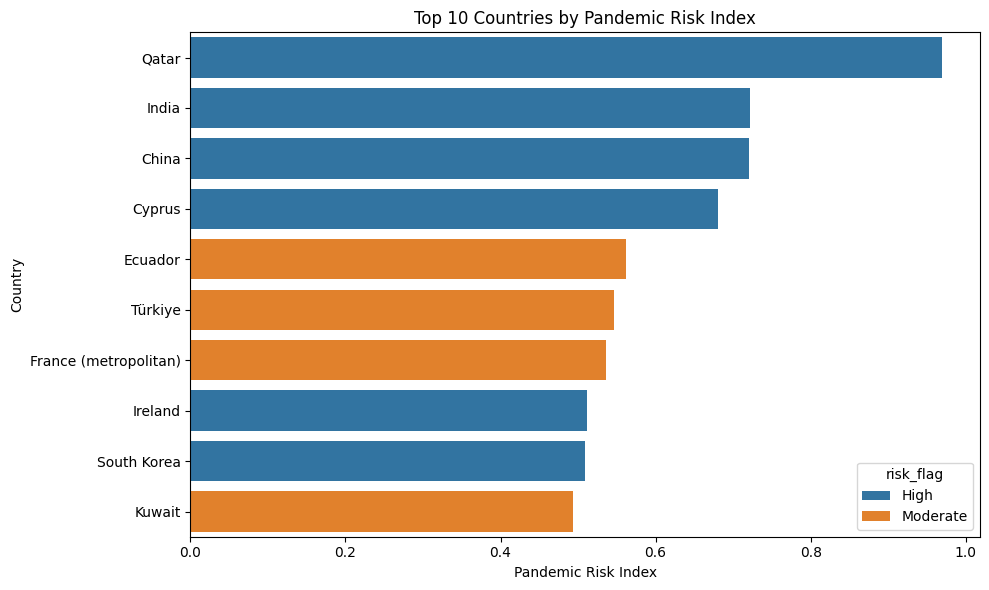

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

top = final_df.sort_values('pandemic_risk_index', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top, x='pandemic_risk_index', y='country_name', hue='risk_flag')
plt.title("Top 10 Countries by Pandemic Risk Index")
plt.xlabel("Pandemic Risk Index")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

In [29]:
filtered = final_df[final_df['risk_flag'].isin(['High', 'Moderate'])]
filtered.to_csv("high_moderate_risk_countries.csv", index=False)

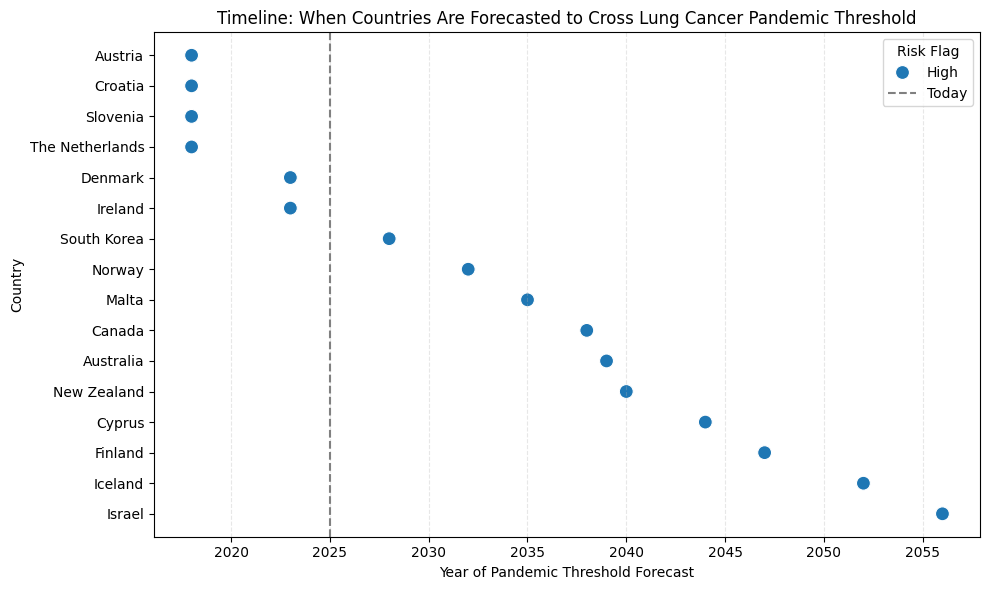

In [33]:
crossing_timeline = final_df[final_df['year_of_pandemic_risk'].notnull()].copy()
crossing_timeline = crossing_timeline.sort_values("year_of_pandemic_risk")

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=crossing_timeline,
    x='year_of_pandemic_risk',
    y='country_name',
    hue='risk_flag',
    s=100
)

plt.axvline(x=2025, linestyle='--', color='gray', label='Today')
plt.xlabel("Year of Pandemic Threshold Forecast")
plt.ylabel("Country")
plt.title("Timeline: When Countries Are Forecasted to Cross Lung Cancer Pandemic Threshold")
plt.legend(title="Risk Flag")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [36]:
%pip install nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.25.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (4.1 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl (18 kB)
Using cached referencing-0.36.2-py3-none-any.whl (26 kB)
Using cached rpds_py-0.25.0-cp39-cp39-macosx_11_0_arm64.whl (359 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [nbformat]5/6 [nbformat]
Note: you may need to restart the kernel to use updated packages.


In [46]:
import plotly.express as px

# Prepare the data
plot_data = final_df.copy()
plot_data['forecast_cagr'] = plot_data['forecast_cagr'].fillna(0).clip(lower=0.001)

# Convert pandemic year to string labels
plot_data['pandemic_year_str'] = plot_data['year_of_pandemic_risk'].apply(
    lambda x: str(int(x)) if pd.notnull(x) else 'Not Forecasted'
)

# Order pandemic years with "Not Forecasted" last
year_order = (
    plot_data[plot_data['year_of_pandemic_risk'].notnull()]
    .sort_values('year_of_pandemic_risk')['pandemic_year_str']
    .unique()
    .tolist()
)
if 'Not Forecasted' in plot_data['pandemic_year_str'].values:
    year_order.append('Not Forecasted')

# 3D plot with dark theme styling
fig = px.scatter_3d(
    plot_data,
    x='pandemic_risk_index',
    y='pandemic_year_str',
    z='forecast_cagr',
    color='risk_flag',
    symbol='risk_flag',
    size='forecast_cagr',
    size_max=15,
    hover_name='country_name',
    hover_data={
        'forecast_cagr': ':.4f',
        'pandemic_risk_index': ':.3f',
        'pandemic_year_str': True
    },
    title='🌌 Lung Cancer Pandemic Risk: 3D View (Dark Theme)',
    category_orders={'pandemic_year_str': year_order},
    template='plotly_dark'
)

# Custom layout adjustments for dark background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Pandemic Risk Index'),
        yaxis=dict(title='Pandemic Year (or Not Forecasted)', type='category'),
        zaxis=dict(title='Forecasted CAGR'),
        bgcolor='#111'
    ),
    scene_camera=dict(eye=dict(x=2, y=1.5, z=0.8)),
    paper_bgcolor='#111',
    plot_bgcolor='#111',
    font=dict(color='white'),
    height=750,
    margin=dict(l=0, r=0, b=0, t=60)
)

# Save dark themed interactive chart
fig.write_html("lung_cancer_risk_3d_dark.html")
print("✅ Dark theme 3D chart saved as 'lung_cancer_risk_3d_dark.html'")

✅ Dark theme 3D chart saved as 'lung_cancer_risk_3d_dark.html'
